In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Read the initial CSV file and apply remove_matched_items
df = pd.read_csv('exp_matches_euclideanl2.csv')

# Function to remove matched items
def remove_matched_items(row):
    missing_filename = row['missing_filename']
    matched_filenames = row['unknowns_matched_filenames'].split(', ')
    l2_values = row['VGG-Face_euclidean_l2'].split(', ')

    if missing_filename in matched_filenames:
        index = matched_filenames.index(missing_filename)
        del matched_filenames[index]
        del l2_values[index]

    row['unknowns_matched_filenames'] = ', '.join(matched_filenames)
    row['VGG-Face_euclidean_l2'] = ', '.join(l2_values)
    return row
df = df.apply(remove_matched_items, axis=1)
# Function to extract Case ID
def extract_case_id(filename):
    return filename.split('/')[1].split('_')[0]

# Function to count matches
def count_matches(case_id, filenames):
    filenames_list = filenames.split(', ')
    return sum(case_id in filename for filename in filenames_list)

# Function to remove duplicates and keep corresponding values aligned
def remove_duplicates_and_align_values(filenames, values):
    unique_filenames = []
    unique_values = []
    seen = set()

    for filename, value in zip(filenames.split(', '), values.split(', ')):
        if filename not in seen:
            seen.add(filename)
            unique_filenames.append(filename)
            unique_values.append(value)

    return ', '.join(unique_filenames), ', '.join(unique_values)


# Extract Case ID for each row
df['Case ID'] = df['missing_filename'].apply(extract_case_id)

# Count the occurrences of each Case ID and filter out rows with unique Case IDs
case_counts = df['Case ID'].value_counts()
case_ids_to_remove = case_counts[case_counts == 1].index
df = df[~df['Case ID'].isin(case_ids_to_remove)]

# Aggregating data
aggregated_data = df.groupby('Case ID').agg({
    'unknowns_matched_filenames': lambda x: ', '.join(x),
    'VGG-Face_euclidean_l2': lambda x: ', '.join(map(str, x))
}).reset_index()

# Remove duplicates and align values
aggregated_data[['unknowns_matched_filenames', 'VGG-Face_euclidean_l2']] = aggregated_data.apply(
    lambda row: remove_duplicates_and_align_values(row['unknowns_matched_filenames'], row['VGG-Face_euclidean_l2']), 
    axis=1, result_type='expand'
)

# Adding matches_counts
aggregated_data['matches_counts'] = aggregated_data.apply(
    lambda row: count_matches(row['Case ID'], row['unknowns_matched_filenames']), axis=1
)

# Save the aggregated data to a new CSV file
aggregated_data.to_csv('aggregated_data_euclideanl2.csv', index=False)


### Summary of the Code

This Python script processes a CSV file containing face recognition match data, primarily focusing on refining and aggregating this data for further analysis. The script performs several steps to clean, transform, and aggregate the information into a more meaningful and concise format.

### Input

**Input:**
- A CSV file named `'exp_matches_euclideanl2.csv'` containing face recognition match data with columns for missing filenames, matched filenames, and Euclidean L2 distance values.

### Processing Steps

The script processes the face recognition match data through several steps as follows:

1. **Read Initial CSV File**: 
   - The script starts by reading data from the CSV file `'matches_test_euclideanl2.csv'`, which contains face recognition match results.

2. **Remove Matched Items Function**: 
   - It defines the `remove_matched_items` function, which processes each row to remove instances where the missing filename appears in the matched filenames. Corresponding L2 distance values are also removed.

3. **Apply Remove Matched Items**:
   - This function is then applied to the entire DataFrame, modifying each row according to the defined logic.

4. **Extract Case ID**:
   - The script extracts a Case ID from each missing filename using the `extract_case_id` function, which assumes a specific naming convention in the filenames.

5. **Filter Out Unique Case IDs**:
   - The script counts the occurrences of each Case ID and filters out rows that have unique Case IDs, focusing only on cases with multiple occurrences.

6. **Aggregating Data**:
   - Data is aggregated by Case ID, combining the matched filenames and L2 values into single strings per Case ID.

7. **Remove Duplicates and Align Values**:
   - The `remove_duplicates_and_align_values` function is used to remove duplicate filenames and align the corresponding L2 values, ensuring unique listings.

8. **Adding Match Counts**:
   - The script adds a new column `matches_counts` to the aggregated data by applying the `count_matches` function. This function counts the number of times each Case ID appears in the matched filenames.

9. **Save Aggregated Data**:
   - Finally, the processed and aggregated data is saved to a new CSV file `'aggregated_data_euclideanl2.csv'`. This file includes Case IDs, aggregated matched filenames, aggregated L2 values, and the counts of matches per Case ID.

### Output

- A new CSV file named `'aggregated_data_euclideanl2.csv'` containing the aggregated data. This file includes columns for Case ID, aggregated matched filenames, aggregated L2 values, and the count of matches per Case ID.


In [6]:
# Load the CSV file
df = pd.read_csv('aggregated_data_euclideanl2.csv')

# Identifying rows where matched_counts is 0
rows_with_zero_matches = (df['matches_counts'] == 0).sum()
# Identifying rows where matched_counts is at least 1
rows_with_at_least_one_match = (df['matches_counts'] >= 1).sum()

print('Total Case IDs with atleast 2 images: ', len(df))
print("Number of Case IDs with no matches in the Pool: ",rows_with_zero_matches)
print("Number of Case IDs with at least one match in the Pool: ",rows_with_at_least_one_match)


Total Case IDs with atleast 2 images:  249
Number of Case IDs with no matches in the Pool:  26
Number of Case IDs with at least one match in the Pool:  223


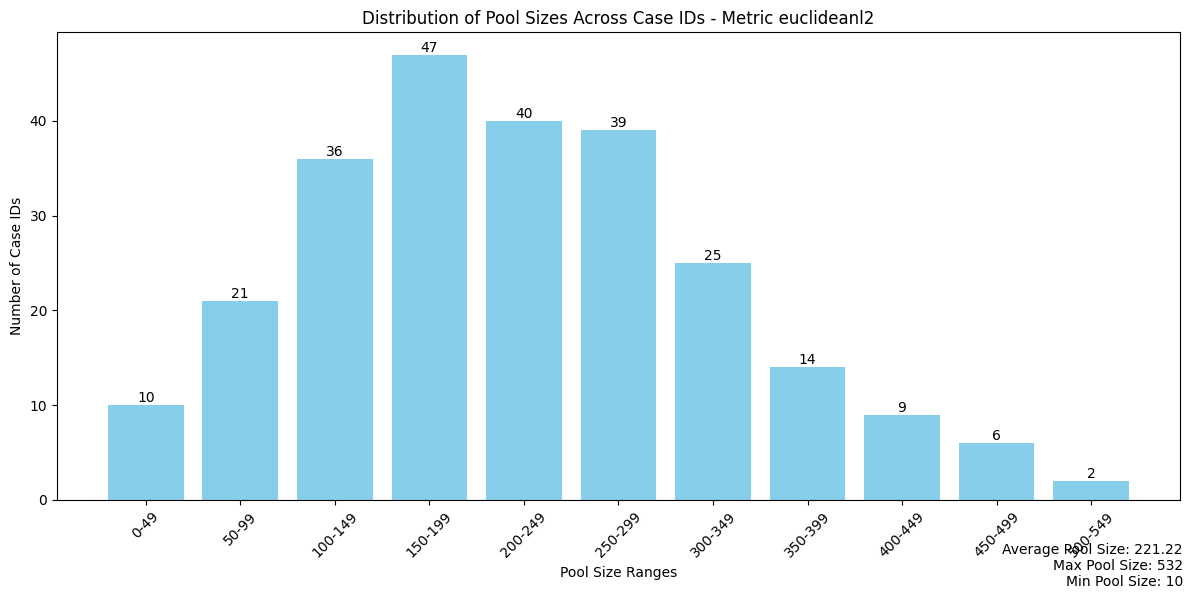

In [3]:
# Load the aggregated data from the CSV file
aggregated_data = pd.read_csv('aggregated_data_euclideanl2.csv')

# Function to count unique filenames and return their count
def count_distinct_filenames(filenames):
    unique_filenames = set(filenames.split(', '))
    return len(unique_filenames)

# Function to sort the pool size categories
def pool_size_sorting_key(category):
    return int(category.split('-')[0])

# Calculate the unique count of filenames for each Case ID
aggregated_data['distinct_filenames_count'] = aggregated_data['unknowns_matched_filenames'].apply(count_distinct_filenames)

# Get the maximum, minimum, and average count of unique filenames
max_count = aggregated_data['distinct_filenames_count'].max()
min_count = aggregated_data['distinct_filenames_count'].min()
average_count = aggregated_data['distinct_filenames_count'].mean()

# Define the pool size boundaries
pool_boundaries = list(range(0, max_count + 50, 50))

# Categorize each Case ID into a corresponding pool size range
def assign_to_pool_size_category(count):
    for index in range(len(pool_boundaries) - 1):
        if pool_boundaries[index] <= count < pool_boundaries[index + 1]:
            return f"{pool_boundaries[index]}-{pool_boundaries[index + 1] - 1}"
    return f"{pool_boundaries[-2]}+"

aggregated_data['pool_size_range'] = aggregated_data['distinct_filenames_count'].apply(assign_to_pool_size_category)

# Calculate the frequency of each pool size range
pool_size_distribution = aggregated_data['pool_size_range'].value_counts()

# Sort the pool size categories
sorted_pool_categories = sorted(pool_size_distribution.keys(), key=pool_size_sorting_key)
sorted_distribution = [pool_size_distribution[category] for category in sorted_pool_categories]

# Plot the pool size distribution as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(sorted_pool_categories, sorted_distribution, color='skyblue')
plt.xlabel('Pool Size Ranges')
plt.ylabel('Number of Case IDs')
plt.title('Distribution of Pool Sizes Across Case IDs - Metric euclideanl2')
plt.xticks(rotation=45)

# Adding text for average, max, and min pool size outside the plot
plt.figtext(0.99, 0.01, f'Average Pool Size: {average_count:.2f}\n'
                         f'Max Pool Size: {max_count}\nMin Pool Size: {min_count}', 
            horizontalalignment='right', verticalalignment='bottom')

# Annotate each bar with its frequency count
for i, count in enumerate(sorted_distribution):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()


This script processes and visualizes data from a CSV file, `aggregated_data_euclideanl2.csv`, which contains aggregated face recognition match data. The goal is to analyze and present the distribution of matches (or 'pool sizes') for each Case ID.

#### Processing Steps:

1. **Load Aggregated Data**: 
   - The script begins by loading data from the CSV file into a pandas DataFrame, `aggregated_data`.

2. **Count Distinct Filenames**: 
   - A function `count_distinct_filenames` is defined to count unique filenames in the match data for each Case ID. It splits the matched filenames string, converts it to a set (to ensure uniqueness), and returns the count.

3. **Calculate Unique Filename Counts**:
   - The script calculates the count of unique filenames for each Case ID and adds this data as a new column, `distinct_filenames_count`, in the DataFrame.

4. **Max, Min, and Average Counts**:
   - It computes the maximum, minimum, and average values of the distinct filename counts across all Case IDs.

5. **Define Pool Size Boundaries**:
   - The script sets up 'pool size' boundaries in increments of 50, starting from 0 up to the maximum count plus 50.

6. **Categorize Case IDs by Pool Size**:
   - Each Case ID is categorized into a 'pool size' range based on its count of unique filenames. A function `assign_to_pool_size_category` is used for this categorization.

7. **Calculate Pool Size Distribution**:
   - The frequency of each pool size category is calculated, which shows how many Case IDs fall into each pool size range.

8. **Sort Pool Size Categories**:
   - A custom sorting function `pool_size_sorting_key` is used to sort the pool size categories numerically for better visualization.

#### Visualization:

- **Bar Chart of Pool Size Distribution**:
  - The script visualizes the distribution of pool sizes as a bar chart. Each bar represents a range of pool sizes, and its height indicates the number of Case IDs in that range.
  - Additional information about the average, maximum, and minimum pool sizes is displayed as text outside the plot area.

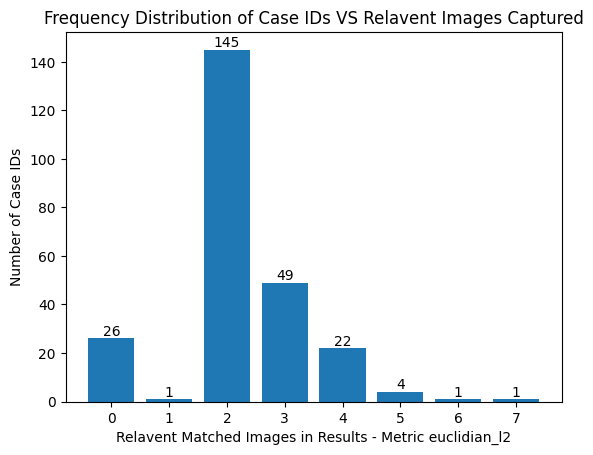

In [8]:

# Load the aggregated data CSV file
aggregated_data = pd.read_csv('aggregated_data_euclideanl2.csv')

# Extract match counts
match_counts = aggregated_data['matches_counts']

# Find the unique match counts and their frequencies
match_count_frequencies = match_counts.value_counts()

# Sort the data for better visualization
match_count_frequencies.sort_index(inplace=True)

# Plotting
plt.bar(match_count_frequencies.index, match_count_frequencies.values)
plt.xlabel('Relavent Matched Images in Results - Metric euclidian_l2')
plt.ylabel('Number of Case IDs')
plt.title('Frequency Distribution of Case IDs VS Relavent Images Captured')

# Adding values on the bars
for index, value in match_count_frequencies.items():
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()


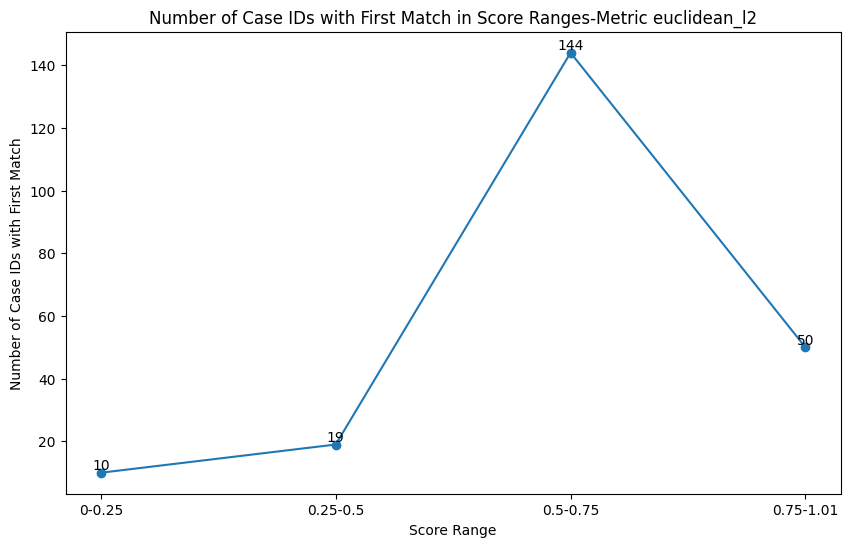

In [21]:
file_path = 'aggregated_data_euclideanl2.csv'

def count_first_matches_in_score_ranges(file_path, score_ranges):
    # Load the CSV data
    data = pd.read_csv(file_path)

    # Initialize counts for each score range
    count_matches = [0] * len(score_ranges)

    # Process each row in the DataFrame
    for index, row in data.iterrows():
        case_id = row['Case ID']
        filenames = row['unknowns_matched_filenames'].split(', ')
        scores = list(map(float, row['VGG-Face_euclidean_l2'].split(', ')))

        # Create a list of tuples (filename, score)
        filename_score_pairs = list(zip(filenames, scores))

        # Sort the list by score
        filename_score_pairs.sort(key=lambda x: x[1])

        # Check if Case ID is in the first match within score ranges
        captured_match = False
        for filename, score in filename_score_pairs:
            for i, score_range in enumerate(score_ranges):
                if case_id in filename and score_range[0] <= score < score_range[1]:
                    count_matches[i] += 1
                    captured_match = True
            
            if captured_match:
                break
            

    return count_matches

# Define score ranges
score_ranges = [(0, 0.25), (0.25, 0.50), (0.50, 0.75), (0.75, 1.01)]
match_counts = count_first_matches_in_score_ranges(file_path, score_ranges)

# Range labels for plotting
range_labels = [f"{r[0]}-{r[1]}" for r in score_ranges]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range_labels, match_counts, marker='o')

# Add text label for each point
for i, txt in enumerate(match_counts):
    plt.text(range_labels[i], match_counts[i], txt, ha='center', va='bottom')

plt.title('Number of Case IDs with First Match in Score Ranges-Metric euclidean_l2')
plt.xlabel('Score Range')
plt.ylabel('Number of Case IDs with First Match')
plt.xticks(range_labels)

plt.show()


### Summary of the Code

The script processes data from a CSV file, `aggregated_data_euclideanl2.csv`, focusing on analyzing the first matches within specific score ranges based on Euclidean L2 distance in face recognition results.

#### Input

- **File Path**: The path to the CSV file containing aggregated face recognition data.
- **Score Ranges**: Predefined ranges of scores (Euclidean L2 distances) to analyze. In this case, these ranges are defined as `[(0, 0.25), (0.25, 0.50), (0.50, 0.75), (0.75, 1.01)]`.

#### Processing Steps

1. **Loading Data**:
   - The CSV file is loaded into a pandas DataFrame.

2. **Initialization**:
   - A list, `count_matches`, is initialized to store the count of first matches within each score range.

3. **Data Iteration and Analysis**:
   - For each row in the DataFrame, the script:
     - Extracts the Case ID, filenames, and scores.
     - Converts scores to floats and pairs them with filenames.
     - Sorts these pairs based on the score to prioritize lower scores (closer matches).
   
4. **Counting First Matches in Score Ranges**:
   - The script checks if the first match (lowest score) for each Case ID falls within any of the predefined score ranges.
   - If a match is found within a range, the corresponding count in `count_matches` is incremented.
   - Only the first match (lowest score) for each Case ID is considered.

5. **Result Compilation**:
   - The counts of first matches in each score range are compiled into the `match_counts` list.

#### Output

- **Visualization**:
  - The results are visualized using a line plot.
  - Each point on the plot represents a score range along the x-axis and the count of first matches in that range along the y-axis.
  - Labels are added to each point to indicate the number of first matches in each range.


The script offers an insightful analysis of face recognition data by focusing on the distribution of first matches across different score ranges. This approach helps to understand how many cases are closely matched (low scores) versus loosely matched (high scores) within the face recognition system. The visual representation further aids in interpreting the distribution of these first matches across different levels of match accuracy.

Number of Case IDs with first match in the top 10 pool: 161
Number of Case IDs with first match in the top 20 pool: 174
Number of Case IDs with first match in the top 30 pool: 181
Number of Case IDs with first match in the top 40 pool: 185
Number of Case IDs with first match in the top 50 pool: 191
Number of Case IDs with first match in the top 60 pool: 200
Number of Case IDs with first match in the top 70 pool: 202
Number of Case IDs with first match in the top 80 pool: 208
Number of Case IDs with first match in the top 90 pool: 209
Number of Case IDs with first match in the top 100 pool: 209
Number of Case IDs with first match in the top 315 pool: 223


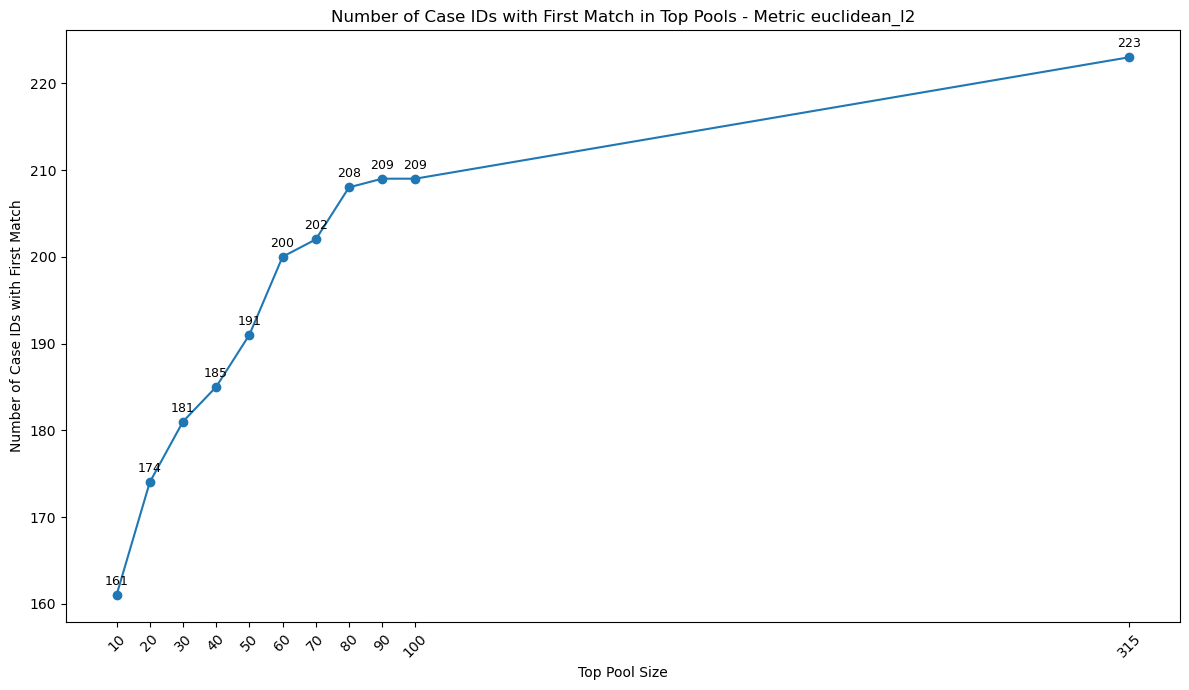

In [1]:
file_path = 'aggregated_data_euclideanl2.csv' 

def count_first_matches_in_top_pool(file_path, top_pool_size):
    # Load the CSV data
    data = pd.read_csv(file_path)

    # Count of Case IDs with first match in top pool
    count_matches = 0

    # Process each row in the DataFrame
    for index, row in data.iterrows():
        case_id = row['Case ID']
        filenames = row['unknowns_matched_filenames'].split(', ')
        scores = list(map(float, row['VGG-Face_euclidean_l2'].split(', ')))

        # Create a list of tuples (filename, score)
        filename_score_pairs = list(zip(filenames, scores))

        # Sort the list by score in descending order
        filename_score_pairs.sort(key=lambda x: x[1])

        # Check if Case ID is in any of the top pool filenames
        for filename, _ in filename_score_pairs[:top_pool_size]:
            if case_id in filename:
                count_matches += 1
                break

    return count_matches


# Define the pool sizes
pool_sizes = list(range(10, 101, 10)) + [315]  # Top 10, 20, ..., 100

match_counts = []

# Iterate over each pool size and calculate counts
for pool_size in pool_sizes:
    count = count_first_matches_in_top_pool(file_path, pool_size)
    match_counts.append(count)
    print(f"Number of Case IDs with first match in the top {pool_size} pool: {count}")

# Plotting the results
plt.figure(figsize=(12, 7))
plt.plot(pool_sizes, match_counts, marker='o')
for i, txt in enumerate(match_counts):
    plt.annotate(txt, (pool_sizes[i], match_counts[i]), textcoords="offset points", xytext=(0,5), ha='center', va='bottom', fontsize=9)
plt.title('Number of Case IDs with First Match in Top Pools - Metric euclidean_l2')
plt.xlabel('Top Pool Size')
plt.ylabel('Number of Case IDs with First Match')
plt.xticks(pool_sizes, rotation=45)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()



### Processing Summary of the Code

The script is designed to analyze face recognition data from a CSV file, focusing on how many Case IDs have their first match within the top N results, where N is defined as the pool size.

#### Input

- **File Path**: The path to a CSV file (e.g., `'aggregated_data_euclideanl2.csv'`) containing face recognition data with information on matches for each Case ID.
- **Top Pool Sizes**: A set of predefined pool sizes (e.g., top 10, top 20, etc.) to analyze.

#### Processing Steps

1. **Loading Data**:
   - The CSV file is loaded into a pandas DataFrame.

2. **Initializing Counter**:
   - A counter (`count_matches`) is initialized to track the number of Case IDs that have their first match within the top pool size.

3. **Iterating Through Data**:
   - The script iterates through each row of the DataFrame. For each Case ID, it:
     - Extracts filenames and their corresponding scores.
     - Pairs filenames with scores and sorts them by scores in ascending order (lower scores indicate closer matches).

4. **Counting First Matches in Top Pools**:
   - For each Case ID, the script checks if the first match (based on score ranking) is within the top N results, as defined by the pool size.
   - If the first match is within the top pool, the counter is incremented.

5. **Iterating Over Pool Sizes**:
   - The script iterates over various predefined pool sizes, applying the counting logic to each pool size.
   - It accumulates the counts of Case IDs with first matches in each top pool size.

#### Output

- **Match Counts for Various Pools**:
  - The script prints out the number of Case IDs with their first match in each top pool size.
  - This information provides insights into how many cases find a potential match within the first set of results, varying by pool size.

- **Visualization**:
  - A line plot is generated to visualize the number of Case IDs with their first match across different pool sizes.
  - Each point on the plot represents a pool size along the x-axis and the count of Case IDs with a first match in that pool along the y-axis.
  - The plot includes annotations for each point, title, axis labels, and is adjusted for clarity and readability.

The script effectively analyzes and visualizes the distribution of first matches in face recognition data across varying pool sizes. This analysis is crucial in understanding the concentration of potential matches in the initial set of results, which can be significant for evaluating the effectiveness of a face recognition system in various scenarios, such as security or identity verification.